In [0]:
##Importing libraries 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data



In [60]:
## Reading the data
df=input_data.read_data_sets("/tmp/data/",one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
###Neural Network Parameters
### 28*28=784

num_inputs = 784 



In [0]:
###Tensorflow data inputs

X=tf.placeholder("float",shape=[None,num_inputs])


In [0]:
### Neural Network training parameters

batch_size=32
num_steps=10000
learning_rate=0.00005
display_step=1000

latent_dim = 10

In [0]:
###Creating Network Architechture

def encoder_layer(x):
    x = tf.reshape(x, [-1, 28, 28, 1])
    conv1 = tf.layers.conv2d(x, 16, (3,3), padding='same', activation=tf.nn.leaky_relu)
    # Now 28x28x16
    maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
    # Now 14x14x16
    conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.leaky_relu)
    # Now 14x14x8
    maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
    # Now 7x7x8
    conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.leaky_relu)
    # Now 7x7x8
    img = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
    # Now 4x4x8
    encoded = tf.contrib.layers.flatten(img)
    encoded = tf.layers.dense(encoded, latent_dim*3, activation=tf.nn.leaky_relu)
    encoded = tf.layers.dense(encoded, latent_dim*2, activation=tf.nn.leaky_relu)
    encoded = tf.layers.dense(encoded, latent_dim, activation=tf.nn.leaky_relu)
    
    encoder = tf.layers.dense(encoded, latent_dim, activation=tf.nn.tanh)
    z_mean = tf.layers.dense(encoded, latent_dim)
    z_std = tf.layers.dense(encoded, latent_dim)
    
    # Sampler: Normal (gaussian) random distribution
    eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                           name='epsilon')
    z = z_mean + tf.exp(z_std / 2) * eps

    return z, z_mean, z_std
    
    

def decoder_layer(x):
    h = 4
    w = 4
    c = 8
    x = tf.layers.dense(x, h*w*c, activation=tf.nn.leaky_relu)
    x = tf.layers.dense(x, h*w*c, activation=tf.nn.leaky_relu)
    x = tf.layers.dense(x, h*w*c, activation=tf.nn.leaky_relu)
    x = tf.layers.dense(x, h*w*c, activation=tf.nn.leaky_relu)
    x = tf.reshape(x, [-1, h, w, c])
    x = tf.image.resize_nearest_neighbor(x, (7,7))
    # Now 7x7x8
    upsample1 = tf.image.resize_nearest_neighbor(x, (7,7))
    # Now 7x7x16
    conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.leaky_relu)
    # Now 7x7x16
    upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
    # Now 14x14x16
    conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.leaky_relu)
    # Now 14x14x32
    upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
    # Now 28x28x32
    conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.leaky_relu)
    # Now 28x28x32

    x = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=tf.nn.leaky_relu)
    #Now 28x28x1

    encoded = tf.contrib.layers.flatten(x)
    encoded = tf.layers.dense(encoded, 784, activation=tf.nn.leaky_relu)
    logits = tf.layers.dense(encoded, 784, activation=tf.nn.leaky_relu)
    decoded = tf.nn.sigmoid(logits, name='decoded')
    return decoded

In [0]:
###Model Architechture

z, z_mean, z_std = encoder_layer(X)
decoder_fun = decoder_layer(z)

In [0]:
####Cost function Evaluation


# Prediction
predicted = decoder_fun


# Define VAE Loss
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)


loss_op = vae_loss(predicted, X)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training = optimizer.minimize(loss_op)

Step 1, Minibatch Loss= 545.1981
Step 1000, Minibatch Loss= 197.5030
Step 2000, Minibatch Loss= 199.8500
Step 3000, Minibatch Loss= 206.8384
Step 4000, Minibatch Loss= 193.2508
Step 5000, Minibatch Loss= 186.4705
Step 6000, Minibatch Loss= 177.8895
Step 7000, Minibatch Loss= 162.2873
Step 8000, Minibatch Loss= 147.3626
Step 9000, Minibatch Loss= 167.1445
Step 10000, Minibatch Loss= 177.5999
Optimization Finished!
Original Images


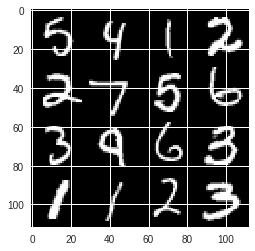

Reconstructed Images


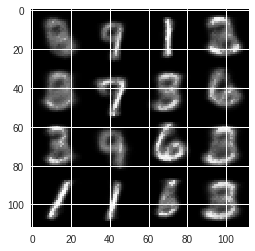

In [67]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

###Staring the Model training Session
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
        batch_x, _ = df.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(training, feed_dict={X: batch_x})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, _ = sess.run([loss_op, training], feed_dict={X: batch_x})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss))

    print("Optimization Finished!")
    
    # Testing
    # Encode and decode images from test set and visualize their reconstruction.
    n = 4
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))


    for i in range(n):

        batch_x, _ = df.test.next_batch(n)

        # Session 
        g = sess.run(decoder_fun, feed_dict={X: batch_x})
    
        # original images
        for j in range(n):
            # Draw the generated digits
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = batch_x[j].reshape([28, 28])
    
        #  reconstructed images
        for j in range(n):
            # Draw the generated digits
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

    print("Original Images")     
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()

   
